In [136]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
from torch import nn
import matplotlib.pyplot as plt
import sphericart.torch as sct
import numpy as np

### Implement Bessel radial basis layer

In [74]:
r = torch.linspace(1,3,120)
r

tensor([1.0000, 1.0168, 1.0336, 1.0504, 1.0672, 1.0840, 1.1008, 1.1176, 1.1345,
        1.1513, 1.1681, 1.1849, 1.2017, 1.2185, 1.2353, 1.2521, 1.2689, 1.2857,
        1.3025, 1.3193, 1.3361, 1.3529, 1.3697, 1.3866, 1.4034, 1.4202, 1.4370,
        1.4538, 1.4706, 1.4874, 1.5042, 1.5210, 1.5378, 1.5546, 1.5714, 1.5882,
        1.6050, 1.6218, 1.6387, 1.6555, 1.6723, 1.6891, 1.7059, 1.7227, 1.7395,
        1.7563, 1.7731, 1.7899, 1.8067, 1.8235, 1.8403, 1.8571, 1.8739, 1.8908,
        1.9076, 1.9244, 1.9412, 1.9580, 1.9748, 1.9916, 2.0084, 2.0252, 2.0420,
        2.0588, 2.0756, 2.0924, 2.1092, 2.1261, 2.1429, 2.1597, 2.1765, 2.1933,
        2.2101, 2.2269, 2.2437, 2.2605, 2.2773, 2.2941, 2.3109, 2.3277, 2.3445,
        2.3613, 2.3782, 2.3950, 2.4118, 2.4286, 2.4454, 2.4622, 2.4790, 2.4958,
        2.5126, 2.5294, 2.5462, 2.5630, 2.5798, 2.5966, 2.6134, 2.6303, 2.6471,
        2.6639, 2.6807, 2.6975, 2.7143, 2.7311, 2.7479, 2.7647, 2.7815, 2.7983,
        2.8151, 2.8319, 2.8487, 2.8655, 

In [90]:
class SphericalBessel(nn.Module):
    def __init__(self, k_max: int = 1, l_max: int = 0):
        super().__init__()
        self.k_max = k_max
        self.l_max = l_max

    def forward(self, r):
        k = torch.linspace(1, self.k_max, self.k_max)
        r = r.to(torch.float64)[:,None]*k[None,:]
        y = torch.zeros([self.l_max]+[s for s in r.shape], dtype=torch.float64)

        lstart = self.l_max + int(torch.sqrt(torch.Tensor([10*self.l_max])))
        j2 = torch.zeros_like(r, dtype=torch.float64)
        j1 = torch.ones_like(r, dtype=torch.float64)

        for i in range(lstart, 0, -1):
            j0 = (2*i+1)/r * j1 - j2
            if i-1<self.l_max:
                y[i-1,...] = j0
            j2 = j1
            j1 = j0


        true_j0 = torch.sinc(r/torch.pi)
        y = y * true_j0/y[0,...]
        return y.to(torch.float32).transpose(0,1)

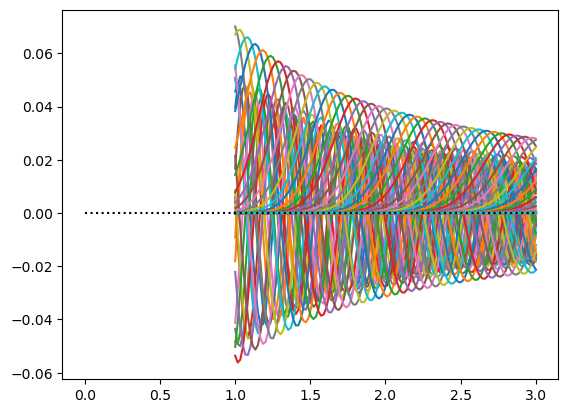

In [93]:
bessel = SphericalBessel(k_max=20, l_max=100)
y = bessel(r)
plt.plot(r, y[:,:,19])
plt.plot([0,torch.max(r)],[0,0], ':k')

### Implement fourier series for time

In [104]:
t = torch.linspace(0,1,200)

In [112]:
class FourierSeries(nn.Module):
    def __init__(self, n_max: int = 1, scale = 1):
        super().__init__()
        self.n_max = n_max
        self.scale = scale

    def forward(self, t):
        n = torch.linspace(1, self.n_max, self.n_max)
        t = t.to(torch.float64)[:,None]*n[None,:]
        
        return torch.cat((torch.sin(t*2*torch.pi/self.scale), torch.cos(t*2*torch.pi/self.scale)), dim=-1)

In [113]:
fourier = FourierSeries(n_max=15, scale=1)
y = fourier(t)
y.shape

torch.Size([200, 30])

torch.Size([200, 10])

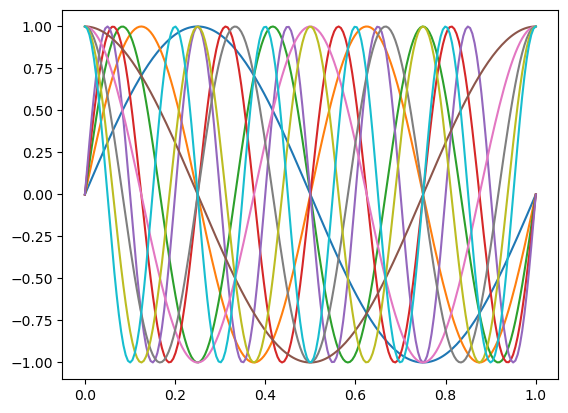

In [114]:
fourier = FourierSeries(n_max=5, scale=1)
y = fourier(t)
plt.plot(t, y)
y.shape

### Implement spherical harmonics for theta and phi

In [138]:
l_max = 5
np.arange(0, l_max+1)

array([0, 1, 2, 3, 4, 5])

In [141]:
l = 0
np.arange(-l, l+1)

array([0])

In [142]:
class SphericalHarmonicsModule(nn.Module):
    def __init__(self, l_max: int = 1):
        super().__init__()
        self.l_max = l_max
        self.sh = sct.SphericalHarmonics(l_max=8, normalized=True)

    def forward(self, xyz):
        sh_values = self.sh.compute(xyz)
        y = torch.zeros(sh_values.shape[0], self.l_max+1, 2*self.l_max+1)

        n = 0
        for l in np.arange(0, self.l_max+1):
            for m in np.arange(-l, l+1):
                y[:, l, m+self.l_max] = sh_values[:,n]
                n = n+1
        
        return y
       

In [170]:
theta = torch.linspace(1*torch.pi/180, torch.pi-1*torch.pi/180, 130)
phi = torch.linspace(0, 2*torch.pi, 260)

x = torch.sin(theta[:,None])*torch.cos(phi[None,:])
y = torch.sin(theta[:,None])*torch.sin(phi[None,:])
z = torch.sin(theta[:,None]).expand(x.shape)

xyz = torch.stack((x.reshape(-1), z.reshape(-1), z.reshape(-1)), dim=-1)

torch.Size([33800, 3, 5])
torch.Size([130, 260, 3, 5])


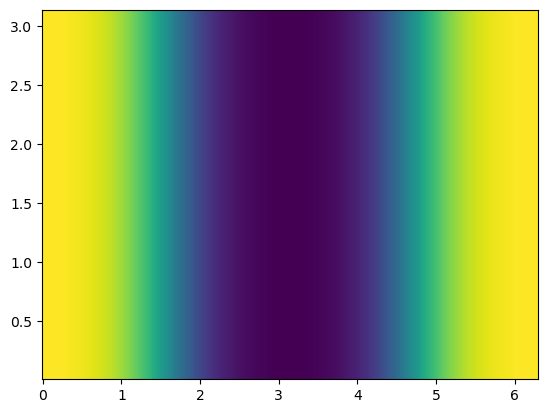

In [175]:
l_max = 2
spherical_harmonics = SphericalHarmonicsModule(l_max=l_max)
y = spherical_harmonics(xyz)
print(y.shape)

y = y.reshape([s for s in x.shape]+[y.shape[1], y.shape[2]])
print(y.shape)
plt.pcolormesh(phi, theta, y[:,:,2, l_max+1])

### Implement orthonormal time spherical NeRF

In [ ]:
class OrthonormalTimeSphericalNeRF(nn.Module):
    def __init__(self,
                d_input: int = 4,
                d_output: int = 2,
                k_max: int = 1, 
                l_max: int = 1, 
                n_max=1):
        super().__init__()
        self.k_max = k_max
        self.l_max = l_max
        self.n_max = n_max

        
        